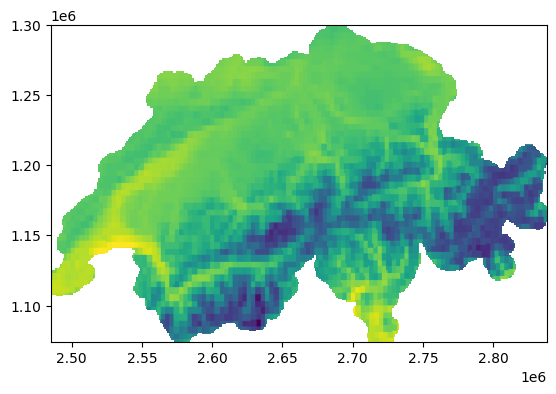

<Axes: >

In [19]:
import rasterio
from rasterio.plot import show
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

fp = r'geo_tiffs/annual_mean_temperature_switzerland_bigger.tif'
img = rasterio.open(fp)
show(img)

In [20]:
mean_temp_data_riox = rioxarray.open_rasterio('geo_tiffs/annual_mean_temperature_switzerland_bigger.tif')
mean_temp_data_riox.name = "data"
df = mean_temp_data_riox.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
mean_temp_data_gpd = gpd.GeoDataFrame(df, crs=mean_temp_data_riox.rio.crs, geometry=geometry)

mean_temp_data_gpd.shape

mean_temp_data_gpd.dropna(inplace=True)

mean_temp_data_gpd.head()

c:\Users\lcsch\anaconda3\envs\data-science\Lib\site-packages\pyproj\crs\_cf1x8.py:515: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


,y,x,band,spatial_ref,data,geometry
196,1299500.0,2681500.0,1,0,1.5,POINT (2681500 1299500)
197,1299500.0,2682500.0,1,0,1.5,POINT (2682500 1299500)
198,1299500.0,2683500.0,1,0,1.5,POINT (2683500 1299500)
199,1299500.0,2684500.0,1,0,1.5,POINT (2684500 1299500)
200,1299500.0,2685500.0,1,0,1.5,POINT (2685500 1299500)


In [21]:
from shapely.wkt import loads

swiss_data_df = pd.read_csv('processed_data/swiss_data_all.csv')
swiss_data_df['geometry'] = swiss_data_df['geometry'].apply(loads)
swiss_data = gpd.GeoDataFrame(swiss_data_df, geometry=swiss_data_df['geometry'])
swiss_data.crs = 'EPSG:2056'

joined = gpd.sjoin(swiss_data, mean_temp_data_gpd, how="left", predicate="contains")
swiss_data['mean_annual_temp'] = joined['data']

In [22]:
# Détection des jointures spatiales qui n'ont pas pu s'effectuer
print(swiss_data['mean_annual_temp'].isna().sum())
print(len(swiss_data))

0
42444


C:\Users\lcsch\AppData\Local\Temp\ipykernel_21932\2240203043.py:4: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  unmatched_points.plot(ax=ax, color='red', markersize=10, label="Unmatched Points")
C:\Users\lcsch\AppData\Local\Temp\ipykernel_21932\2240203043.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
C:\Users\lcsch\AppData\Local\Temp\ipykernel_21932\2240203043.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


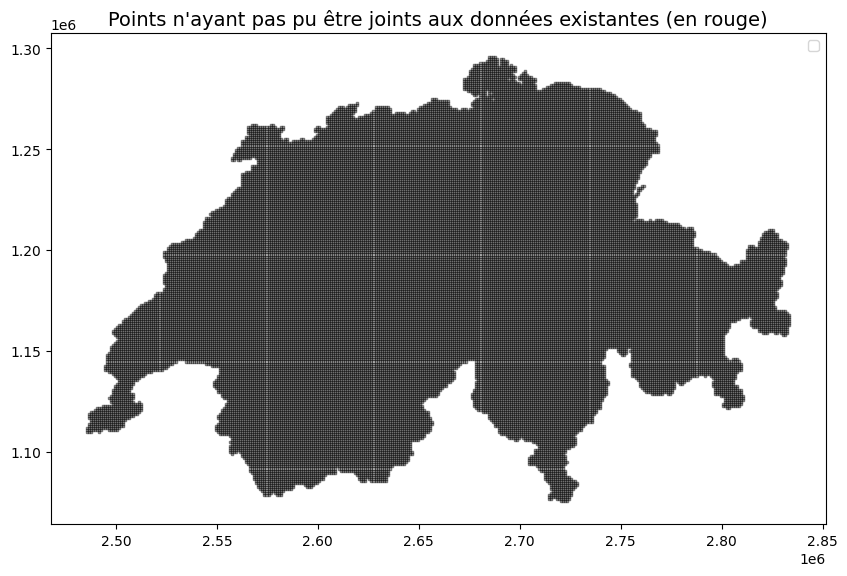

In [23]:
unmatched_points = joined[joined['index_right'].isna()]  # 'index_right' est NaN si aucun polygone ne correspond
fig, ax = plt.subplots(figsize=(10, 10))
swiss_data.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label="Swiss Data Polygons")
unmatched_points.plot(ax=ax, color='red', markersize=10, label="Unmatched Points")
ax.set_title("Points n'ayant pas pu être joints aux données existantes (en rouge)", fontsize=14)
ax.legend()
plt.show()

In [24]:
# Retirer les éventuels points manquants
count_before = len(swiss_data)
swiss_data.dropna(axis=0, subset=['mean_annual_temp'], inplace=True)
count_after = len(swiss_data)
print('Before | After :',count_before,count_after)
print(swiss_data['mean_annual_temp'].isna().sum())

Before | After : 42444 42444
0


C:\Users\lcsch\AppData\Local\Temp\ipykernel_21932\1484308639.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


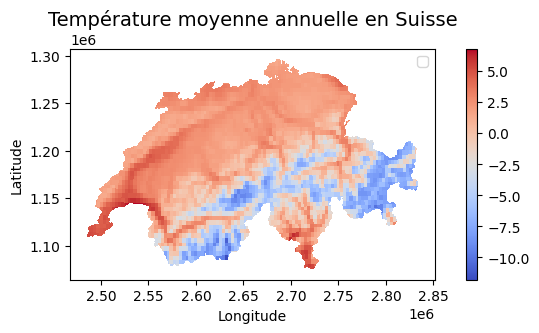

In [ ]:
# Visualisation des données augmentées avec la température annuelle
fig, ax = plt.subplots(figsize=(8, 3))
swiss_data.plot(column='mean_annual_temp', ax=ax, legend=True,
                cmap='coolwarm')
ax.set_title('Température moyenne annuelle en Suisse', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [26]:
# Sauvegarde du fichier
swiss_data.to_csv('processed_data/swiss_data_all_with_temp.csv', mode='w')